In [1]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug
import cv2

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Misc
import progressbar
import random
import glob
import shutil
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


### Helpers

In [74]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()
    
# Show model history
def show_model_history(modelHistory, model_name, w=12, h=6):
    history = pd.DataFrame()
    history['Train Loss'] = modelHistory.history['loss']
    history['Validation Loss'] = modelHistory.history['val_loss']
    history['Train Accuracy'] = modelHistory.history['acc']
    history['Validation Accuracy'] = modelHistory.history['val_acc']
    history.plot(figsize=(w, h))
    plt.title('Model: {} - Train & Validation Loss & Accuracy'.format(model_name))
    plt.show()

    
# Show model history v2
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Directory

In [3]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\09-dog-cat-classifier\\images'
# os.chdir(PATH)

# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory
train_dir = MAIN_PATH / 'original_train'

# Path to test directory
test_dir = MAIN_PATH / 'original_test'

### Get training data

In [4]:
filenames = os.listdir('images/original_train')
print('Total Images: ', len(filenames))
print(filenames[0:3])

Total Images:  25000
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg']


In [5]:
# Classification
labels = []

# Loop through file names to get type
for filename in filenames:
    label = filename.split('.')[0]
    if label == 'dog':
        labels.append(1)
    else:
        labels.append(0)

In [6]:
df = pd.DataFrame({
    'filename': filenames,
    'label': labels
})

df = df.sample(frac=1).reset_index(drop=True)

In [7]:
df.head()

,filename,label
0,dog.2633.jpg,1
1,cat.6678.jpg,0
2,dog.1873.jpg,1
3,dog.6346.jpg,1
4,dog.134.jpg,1


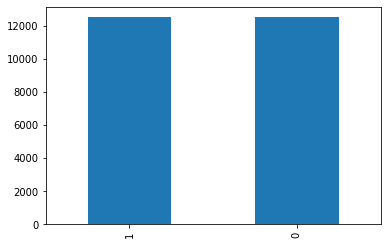

In [8]:
df['label'].value_counts().plot.bar()

Frequency of label :


,Count,Percentage
1,12500,50.0
0,12500,50.0


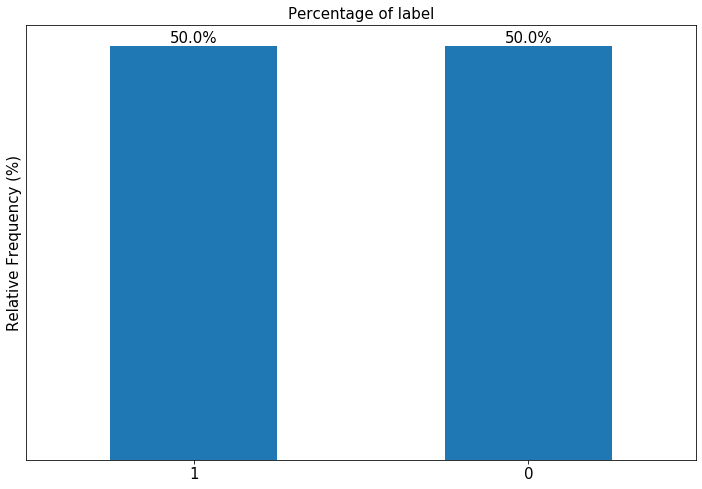

In [9]:
freq_table(df['label'])

### Sample

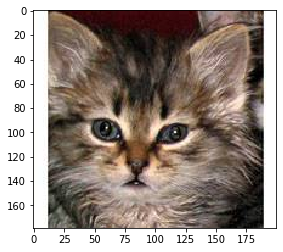

In [10]:
sample_img = random.choice(filenames)
sample_image = load_img('images/original_train/'+sample_img)
plt.imshow(sample_image)

### Model

Pre-trained weights can be automatically loaded upon instantiation (weights='imagenet' argument in model constructor for all image models.

[fchollet github](https://github.com/fchollet/deep-learning-models)

In [39]:
WIDTH = 224
HEIGHT = 224
EPOCHS = 50
BATCH_SIZE = 100

In [40]:
input_shape = (WIDTH, HEIGHT, 3)

In [41]:
base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

In [42]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [43]:
for layer in base_model.layers[:15]:
    layer.trainable=False

for layer in base_model.layers[15:]:
    layer.trainable=True

In [44]:
base_model.layers

In [45]:
last_layer = base_model.get_layer('block5_pool') # OR base_model.output
last_output = last_layer.output

In [46]:
last_layer

In [47]:
last_output

<tf.Tensor 'block5_pool_1/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

### Create new fully connected layers

In [48]:
# Flatten
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

### Create model

In [49]:
model = Model(inputs=base_model.input, outputs=outputs)

In [50]:
model.compile(
    loss='binary_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [51]:
df.dtypes

filename    object
label       object
dtype: object

### Prepare train and test data

In [52]:
df['label'] = df['label'].astype(str)

In [53]:
df[0:3]

,filename,label
0,dog.2633.jpg,1
1,cat.6678.jpg,0
2,dog.1873.jpg,1


In [54]:
train_df, validation_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validation_df = validation_df.reset_index()

In [55]:
total_train = train_df.shape[0]
total_validation = validation_df.shape[0]

In [56]:
print('Train Samples: ', total_train)
print('Validation Samples: ', total_validation)

Train Samples:  22500
Validation Samples:  2500


### Generate images

In [60]:
train_dir = os.path.join('images', 'original_train - Copy')
# if not os.path.exists(train_dir):
#     os.mkdir(train_dir)

# validation_dir = os.path.join('images', 'validation')
# if not os.path.exists(validation_dir):
#     os.mkdir(validation_dir)

In [61]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory=train_dir, 
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df, 
    directory=train_dir, 
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Test generate

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [59]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

timg = load_img('images/original_train/cat.1.jpg')  # this is a PIL image
tx = img_to_array(timg)  # this is a Numpy array with shape (3, 150, 150)
tx = tx.reshape((1,) + tx.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(tx, batch_size=1,
                          save_to_dir='images/samples', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

### Sample image

Found 5 validated image filenames belonging to 2 classes.


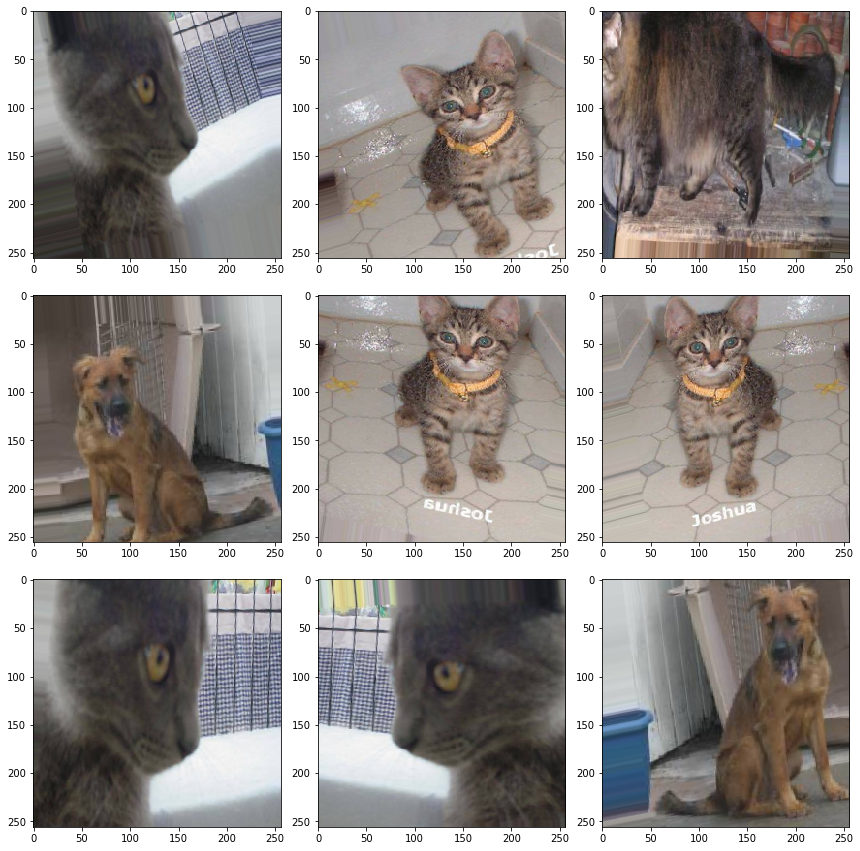

In [64]:
example_df = train_df.sample(n=5).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_dir, 
    x_col='filename',
    y_col='label',
    class_mode='binary'
)

# Set figure space
plt.figure(figsize=(12, 12))

# Loop through images generated
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [ ]:
callbacks_list = [
    ModelCheckpoint(filepath='best_model_updated.h5', monitor='val_loss', save_best_only=True)
]

### Fit the model

In [67]:
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validation // BATCH_SIZE,
    steps_per_epoch=total_train // BATCH_SIZE,
    callbacks=callbacks_list
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
225/225 [==============================] - 211s 936ms/step - loss: 0.5914 - acc: 0.6785 - val_loss: 0.3181 - val_acc: 0.8884
Epoch 2/5
225/225 [==============================] - 200s 887ms/step - loss: 0.3285 - acc: 0.8556 - val_loss: 0.2030 - val_acc: 0.9144
Epoch 3/5
225/225 [==============================] - 206s 913ms/step - loss: 0.2456 - acc: 0.8935 - val_loss: 0.1629 - val_acc: 0.9356
Epoch 4/5
225/225 [==============================] - 220s 979ms/step - loss: 0.2051 - acc: 0.9125 - val_loss: 0.1397 - val_acc: 0.9440
Epoch 5/5
225/225 [==============================] - 194s 861ms/step - loss: 0.1857 - acc: 0.9218 - val_loss: 0.1273 - val_acc: 0.9476


### Evaluation

[Keras Doc](https://keras.io/models/sequential/) - look up evaluate_generator()

In [68]:
# Using Keras model.evaluate_generator
loss, accuracy = model.evaluate_generator(validation_generator, total_validation // BATCH_SIZE, workers=12)

In [72]:
print('Test: accuracy = {:.4f} loss = {:.4f} '.format(accuracy, loss))

Test: accuracy = 0.9452 loss = 0.1302 


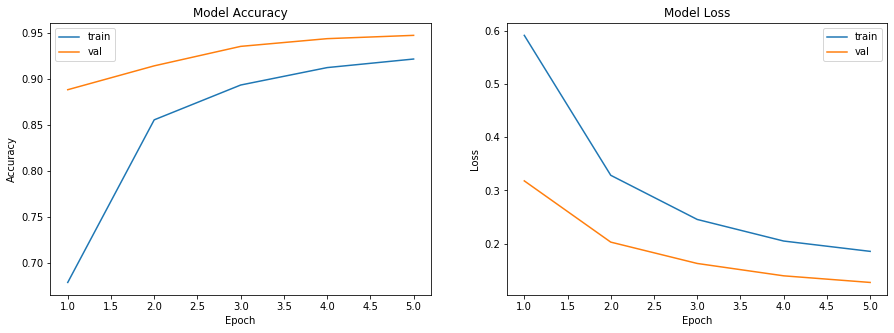

In [75]:
plot_model_history(history)

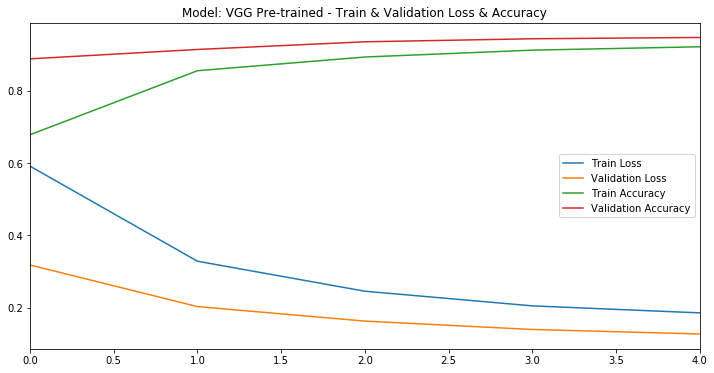

In [78]:
show_model_history(history, model_name='VGG Pre-trained')

### Confusion Matrix

In [81]:
Y_val = validation_df['label']
y_pred =  model.predict_generator(validation_generator, steps=total_validation // BATCH_SIZE)

In [86]:
Y_val_int = validation_df['label'].astype('int')

In [82]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1, 0)

In [87]:
acc = accuracy_score(Y_val_int, y_final)*100
cm = confusion_matrix(Y_val_int, y_final)

print('Acc: ', acc)
print('CM:' )
cm

Acc:  50.88
CM:


array([[577, 616],
       [612, 695]], dtype=int64)

========= Confusion Matrix =========


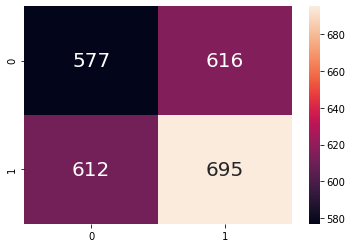


========= Evaluation Metrics =========
Accuracy: 50.880%
Precision: 48.528%
Recall: 48.365%
F1-score: 48.447%

========= Training Accuracy =========
Train acc: 92.18
FN:  616
Total:  2500


In [88]:
tn = cm[1][1]
fp = cm[1][0]
fn = cm[0][1]
tp = cm[0][0]

print('========= Confusion Matrix =========')
sns.heatmap(cm, 
            annot=True,
            fmt='d',
            annot_kws={'size': 20})
plt.show()

print('\n========= Evaluation Metrics =========')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.3f}%'.format(acc))
print('Precision: {:.3f}%'.format(precision))
print('Recall: {:.3f}%'.format(recall))
print('F1-score: {:.3f}%'.format(2*precision*recall/(precision+recall)))

print('\n========= Training Accuracy =========')
print('Train acc: {}'.format(np.round((history.history['acc'][-1])*100, 2)))
print('FN: ', fn)
print('Total: ', tn+fp+fn+tp)

### Show predicted results (wrong/correct)

In [90]:
validation_df['pred_value'] = np.where(y_pred > threshold, 1,0)

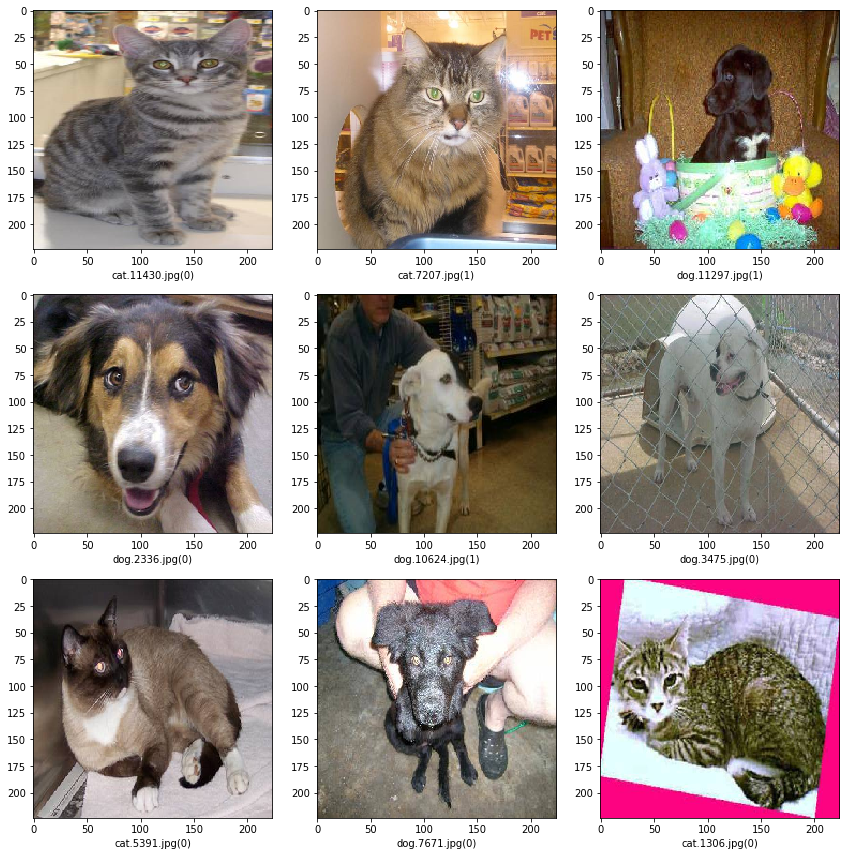

In [94]:
sample_val = validation_df.sample(n=9).reset_index()
sample_val.head()
plt.figure(figsize=(12, 12))
for index, row in sample_val.iterrows():
    filename = row['filename']
    category = row['pred_value']
    img = load_img('images/original_train - Copy/'+filename, target_size=(224, 224))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()